In [1]:
# poröse layer und air-layer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import csv
import numpy as np
from numpy import cos, sin, pi, sqrt, abs, dot


In [2]:
# JAC-Modell
# Porosität des porösen Materials (Φ)
# Dichte der Flüssigkeit (normalerweise Luft) (ρ)
# Viskosität des Fluids (η)
# Strömungswiderstand des porösen Materials (σ)
# Frequenz der Schallwelle (f)
# Thermische Parameter eines porösen Materials (Pr, Le)
# Wärmekapazität des porösen Materials (Cp)
# Porengröße des porösen Materials (d)


def JAC(f, dichte, phi, alpha_unend, sigma, gamma, P0, viskosität_L, thermisch_L, Pr, viskosität):

    K0 = gamma * P0
    omega = 2*pi*f
    try:
        G1 = sigma * phi / (alpha_unend * dichte * omega)
    except ZeroDivisionError:
        G1_dot = float('inf')  # other number
        print('biite richtig Zahl eingeben')
    
    try:
        G2 = 4*((alpha_unend)**2) * dichte * viskosität * omega / ((sigma*phi*viskosität_L)**2)
    except ZeroDivisionError:
        G2 = float('inf')
        print('biite richtig Zahl eingeben')

    try:
        G1_dot = 8*viskosität / (dichte * Pr * ((thermisch_L)**2) * omega)
    except ZeroDivisionError:
        G1_dot = float('inf')
        print('biite richtig Zahl eingeben')
        
    try:
        G2_dot = dichte * Pr * ((thermisch_L)**2) * omega / (16*viskosität)
    except ZeroDivisionError:
        G2_dot = float('inf')
        print('biite richtig Zahl eingeben')

    try:
        dichte_p = dichte * alpha_unend * (1- 1j*G1*sqrt(1+1j*G2)) / phi
    except (ZeroDivisionError, ValueError):
        dichte_p = float('inf')
        print('biite richtig Zahl eingeben')

    K_p = K0*phi**(-1) / (gamma - (gamma-1)*((1- 1j*G1_dot*sqrt(1+ 1j*G2_dot))**-1))
    
    try:
        kp = omega * sqrt(dichte_p/K_p)
    except ZeroDivisionError:
        kp = float('inf')
        print('biite richtig Zahl eingeben')
    Zp = sqrt(dichte_p*K_p)

    return Zp, kp

In [3]:
def tmm(
        theta: float,
        k0: float,
        k1: float,
        L1: float,
        Z1: float,
        k2: float,
        L2: float,
        Z2: float
    ) -> None:
    
    ##  k_x, k_z bei Eingallswinkel theta
    k_0x = k0*sin(theta)
    k_1x = k_0x
    k_2x = k2*sin(theta)

    k_1z = sqrt(k1**2 - k_1x**2)
    k_2z = sqrt(k2**2 - k_2x**2)

    # T1, T2, T3 definieren

    T1 = np.array([[cos(k_1z*L1), 1j*Z1*(k1/k_1z)*sin(k_1z*L1)],
                   [(1j/Z1)*(k_1z/k1)*sin(k_1z*L1), cos(k_1z*L1)]])

    T2 = np.array([[cos(k_2z*L2), 1j*Z2*(k2/k_2z)*sin(k_2z*L2)],
                   [(1j/Z2)*(k_2z/k2)*sin(k_2z*L2), cos(k_2z*L2)]])

    # Rigid Backed
    T3 = np.array([[1, 0],  
                   [0, 1]])

    # T_total berechnen
    T_total = dot(T1, T2)

    return T_total

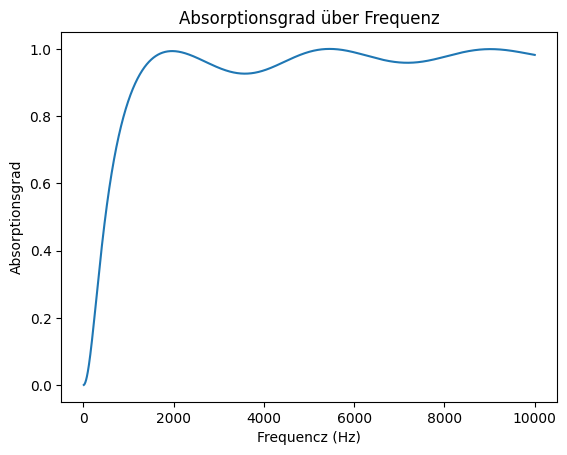

In [4]:
## Schräge Inzidenz (Oblique Incidence)
## Paremeter 
luft_c = 344
luft_dichte = 1.213  # dichte von Luft-Schicht

# Parameters
dichte = 1.213
phi = 0.98
alpha_unend = 1.01
sigma = 20600
gamma = 1.4
P0 = 101325 # Pa
viskosität_L = 85*10**(-6)
thermisch_L = viskosität_L*2
Pr = 0.71
viskosität = 1.839*10**(-5)

# Frequenz Bereich
L1 = float(input('poroese Schicht Dicke(mm):'))
L1 = L1/1000
L2 = float(input('Luft Schicht Dicke(mm):'))
L2 = L2/1000
winkel = float(input('Einfallswinkel(Grad):'))
theta = pi*winkel/180 # theta nur rad sein können
frequenz_min = 10
frequenz_max = float(input('max. frequenz:'))
frequenzbereich = np.arange(frequenz_min, frequenz_max)

alphas = np.array([]) # Array speichert Absorptionsgrad

# Impedanz
Z0 = luft_dichte * luft_c
#Z2 = luft_dichte * luft_c  # Luft-Schicht

for f in frequenzbereich:
    Z1, k1 = JAC(f, dichte, phi, alpha_unend, sigma, gamma, P0, viskosität_L, thermisch_L, Pr, viskosität)
    Z2 = luft_dichte * luft_c

    k0 = 2*pi*f / (luft_c)
    k2 = k0

    T_total = tmm(theta,k0,k1,L1,Z1,k2,L2,Z2)
    
    # Absorptionsgrad berechnen
    R = (T_total[0, 0]*cos(theta) - Z0*T_total[1, 0]) / (T_total[0, 0]*cos(theta) + Z0*T_total[1, 0]) # Reflexionskoeffizient
    alpha = 1 - (abs(R)**2)
    alphas = np.append(alphas, alpha)

# Ersetzen der Werte durch 0
alphas[(alphas < 0.000001) & (alphas > 0)] = 0

# Diagramm, Grad über Frequenz
plt.plot(frequenzbereich,alphas)
plt.xlabel('Frequencz (Hz)')
plt.ylabel('Absorptionsgrad')
plt.title('Absorptionsgrad über Frequenz')
plt.show()